In [1]:
#Here we are installing kaggle library
!pip install kaggle

In [2]:
#Configuring the path of kaggle.json file
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp '//content/drive/MyDrive/kaggle.json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [3]:
#API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

 93% 75.0M/80.9M [00:00<00:00, 166MB/s]
100% 80.9M/80.9M [00:00<00:00, 165MB/s]


In [4]:
#Extracting the zip file that contains the dataset
!unzip '/content/sentiment140.zip'

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


#Importing the libraries


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#printing the stop words in english
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#Data Processing

In [8]:
#loading the data from csv file in pandas dataframe
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding = 'ISO-8859-1')


In [9]:
#Total rows and columns
twitter_data.shape

(1599999, 6)

In [10]:
#printing first five rows of dataframe
twitter_data.head(5)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [11]:
#Naming the column and reading the dataset again
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names = column_names, encoding = 'ISO-8859-1')


In [12]:
#Total rows and columns
data.shape

(1600000, 6)

In [13]:

data = data.sample(n=250000, random_state=42)


In [14]:
data.shape

(250000, 6)

In [15]:
# Counting the number of missing values in dataset
data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [16]:
#Checking the distribution of target column
data['target'].value_counts()

4    125201
0    124799
Name: target, dtype: int64

Convert the target '4' to '1'

In [17]:
data.replace({'target':{4:1}}, inplace = True)


*   0 --> Negative Tweet  
*   1 --> Positive Tweet



Top 10 most active members

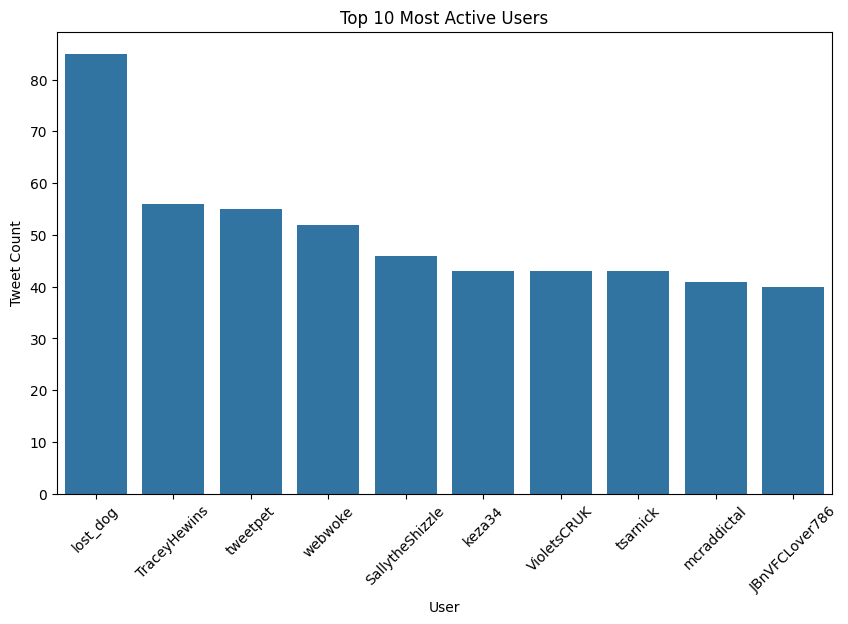

In [18]:
user_frequency = data['user'].value_counts().head(10)  # Top 10 users
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x=user_frequency.index, y=user_frequency.values)
plt.xlabel('User')
plt.ylabel('Tweet Count')
plt.title('Top 10 Most Active Users')
plt.xticks(rotation=45)
plt.show()

**Stemming**


Stemming is the process of reducing a word to its Root word

In [19]:
port_stem = PorterStemmer()

In [20]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content


In [21]:
data['stemmed_content'] = data['text'].apply(stemming)

In [22]:
data.head()

,target,id,date,flag,user,text,stemmed_content
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,chrishasboob ahhh hope ok
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",misstoriblack cool tweet app razr
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,tiannachao know famili drama lame hey next tim...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,school email open geographi stuff revis stupid...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,upper airway problem


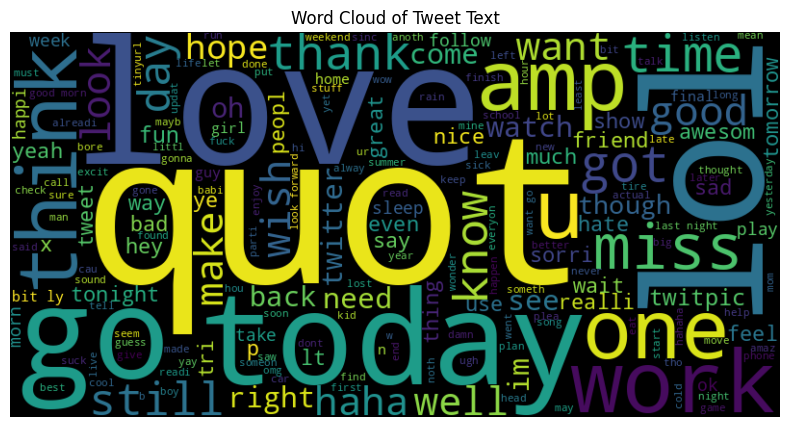

In [23]:
from wordcloud import WordCloud

# Assuming 'text_data' is your text data
wordcloud = WordCloud(width=800, height=400).generate(' '.join(data['stemmed_content']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()


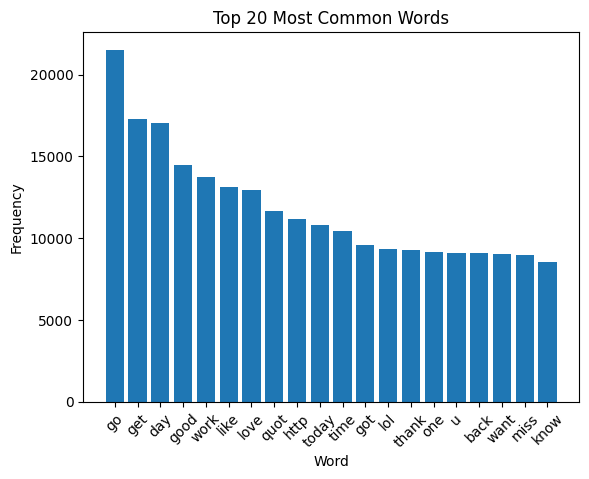

In [24]:
from collections import Counter

word_counts = Counter(' '.join(data['stemmed_content']).split())
top_words = word_counts.most_common(20)  # Top 20 words
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()


In [25]:
print(data['stemmed_content'])

541200                             chrishasboob ahhh hope ok
750                        misstoriblack cool tweet app razr
766711     tiannachao know famili drama lame hey next tim...
285055     school email open geographi stuff revis stupid...
705995                                  upper airway problem
                                 ...                        
396602                            go rochest today like hope
1372237    ilanrubin beaker fave scienc chem nerd anim pr...
35163      god suck aunt flo came yesterday cramp like mo...
1383270                       go cinema friend seem nice day
380269           still feel alittl sick wanna go alisonnnnnn
Name: stemmed_content, Length: 250000, dtype: object


In [26]:
print(data['target'])

541200     0
750        0
766711     0
285055     0
705995     0
          ..
396602     0
1372237    1
35163      0
1383270    1
380269     0
Name: target, Length: 250000, dtype: int64


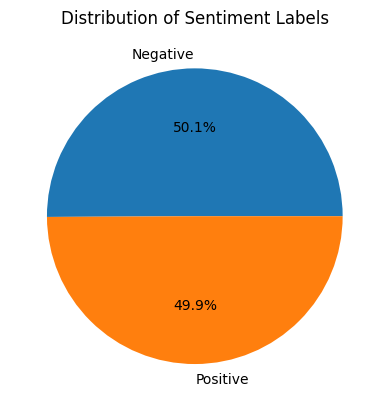

In [27]:
label_mapping = {0: 'Negative', 1: 'Positive'}

mapped_labels = data['target'].map(label_mapping)

plt.pie(mapped_labels.value_counts(), labels=label_mapping.values(), autopct='%1.1f%%')
plt.title('Distribution of Sentiment Labels')
plt.show()

<ipython-input-28-ec0bd9cbba4e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


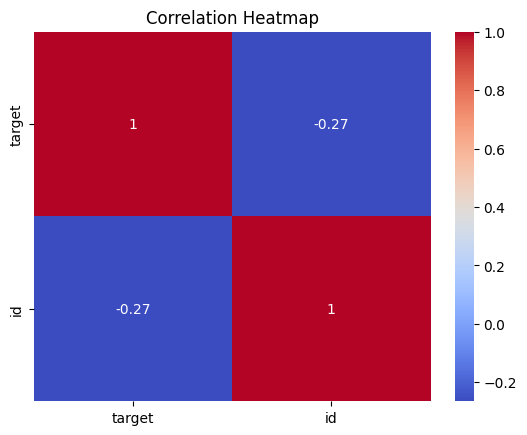

In [28]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [29]:
#Separating the data and label
X = data['stemmed_content'].values
Y = data['target'].values

In [30]:
print(X)

['chrishasboob ahhh hope ok' 'misstoriblack cool tweet app razr'
 'tiannachao know famili drama lame hey next time u hang kim n u guy like sleepov whatev ill call u'
 ...
 'god suck aunt flo came yesterday cramp like mofo need pain killer mayb get back sleep'
 'go cinema friend seem nice day'
 'still feel alittl sick wanna go alisonnnnnn']


In [31]:
print(Y)

[0 0 0 ... 0 1 0]


Splitting the data to training data and test data


In [32]:
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 2)

In [33]:
print(X.shape, X_train.shape, X_test.shape)

(250000,) (200000,) (50000,)


In [34]:
print(X_train)

['steph thtgirl awe one cutest thing ever heard jj statu'
 'dannymcfli http twitpic com iqyf hot last night amaz thx guy'
 'miss pipedream lj liesss lol oh close birthday day next month haha well thank st say happi bday'
 ... 'tire' 'joshsharp curs' 'eat yummi chocol yogurt mami made']


In [35]:
print(X_test)

['bum miss pair sunglass mainli huge possibl actual stolen' 'snappl gone'
 'ahh itsciara nah cant go jess show gotta go sacramento bum' ...
 'red eye get better sun shine make investig school'
 'knitkat kind odd seem like let answer messag twitter realli affect life'
 'janelli poo jeez snooz clock till lol hey tell charli laptop']


In [36]:
#converting the textual data to numerical data
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
print(X_train)

  (0, 106890)	0.32288159060199145
  (0, 55766)	0.3755014929955127
  (0, 46045)	0.2636946629408585
  (0, 34989)	0.22527999036490023
  (0, 113641)	0.19865303473763957
  (0, 24606)	0.35157521181239093
  (0, 83846)	0.16961383812677155
  (0, 7902)	0.32530691843914594
  (0, 114033)	0.4696801839458131
  (0, 107092)	0.3408798610286684
  (1, 44348)	0.24206555083011108
  (1, 114111)	0.33397308042216717
  (1, 3727)	0.2653275261251122
  (1, 80873)	0.20608321240991545
  (1, 63654)	0.2160391944619404
  (1, 48363)	0.2707552172501628
  (1, 51863)	0.5611498915185155
  (1, 22119)	0.19904437943939335
  (1, 117785)	0.24073696106983503
  (1, 48709)	0.185374718696742
  (1, 25697)	0.3875435541860344
  (2, 9763)	0.2589052368899679
  (2, 45293)	0.17668579033214207
  (2, 98907)	0.1777130502342574
  (2, 106507)	0.23717349853952424
  :	:
  (199993, 116795)	0.24800971661387247
  (199993, 108611)	0.22361741263442794
  (199993, 44684)	0.18668247399321056
  (199994, 35361)	0.5753927584184219
  (199994, 17849)	0.53512

In [38]:
print(X_test)

  (0, 108762)	0.39533091899434164
  (0, 107645)	0.3831476173255335
  (0, 89522)	0.31059233059462854
  (0, 85413)	0.3541250740247326
  (0, 74642)	0.18411291971845323
  (0, 69420)	0.4229568133017285
  (0, 48782)	0.31368493640669554
  (0, 15741)	0.31407169600310875
  (0, 884)	0.25536229412989275
  (1, 104357)	0.8841233883166952
  (1, 42626)	0.46725350103707763
  (2, 102105)	0.24062155505659621
  (2, 97536)	0.4728543614197025
  (2, 78764)	0.3566262653828497
  (2, 55037)	0.37417893619594667
  (2, 43014)	0.2755840406825523
  (2, 42347)	0.314738086690756
  (2, 16999)	0.24962891156702807
  (2, 15741)	0.33185736260938214
  (2, 1846)	0.322284534804243
  (3, 127361)	0.1829427713556041
  (3, 127117)	0.1744444419539301
  (3, 105413)	0.1819295953686075
  (3, 103370)	0.2760488330467548
  (3, 96883)	0.2951669141976889
  :	:
  (49997, 51707)	0.5161688188484493
  (49997, 41242)	0.1902081875579731
  (49997, 35570)	0.33387544648350065
  (49997, 11121)	0.26973767610860633
  (49998, 117828)	0.22223111358170

Training the Machine Learning model

Logistic Regression

In [39]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train,Y_train)

LogisticRegression(max_iter=1000)

Model Evaluation

Accuracy Score


In [40]:
# Accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train,X_train_prediction)


In [41]:
print("Accuracy score on the Training data:",training_data_accuracy)

Accuracy score on the Training data: 0.81963


In [42]:
# Accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test,X_test_prediction)


In [43]:
print("Accuracy score on the Testing data:",test_data_accuracy)

Accuracy score on the Testing data: 0.76902


Confusion Matrix

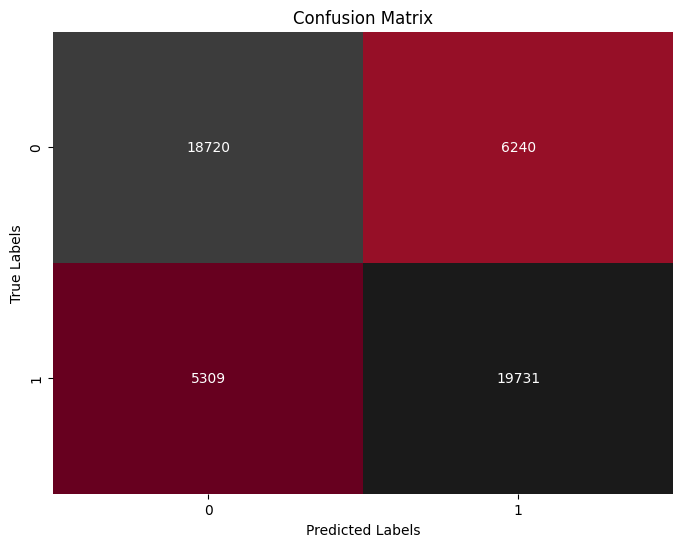

In [44]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="RdGy", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Saving the Trained Model

In [45]:
from sklearn.linear_model import LogisticRegression
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the model to Google Drive
joblib.dump(model, '/content/drive/My Drive/logistic_regression_model.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/My Drive/logistic_regression_model.pkl']